<a href="https://colab.research.google.com/github/tanjascats/dissertation/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [47]:
# fetch dataset
breast_cancer = fetch_ucirepo(id=14)

# data (as pandas dataframes)
X = breast_cancer.data.features
y = breast_cancer.data.targets

# metadata
print(breast_cancer.metadata)

# variable information
print(breast_cancer.variables)

{'uci_id': 14, 'name': 'Breast Cancer', 'repository_url': 'https://archive.ics.uci.edu/dataset/14/breast+cancer', 'data_url': 'https://archive.ics.uci.edu/static/public/14/data.csv', 'abstract': 'This breast cancer domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia. This is one of three domains provided by the Oncology Institute that has repeatedly appeared in the machine learning literature. (See also lymphography and primary-tumor.)', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 286, 'num_features': 9, 'feature_types': ['Categorical'], 'demographics': ['Age'], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Mar 07 2024', 'dataset_doi': '10.24432/C51P4M', 'creators': ['Matjaz Zwitter', 'Milan Soklic'], 'intro_paper': None, 'additional_info': {'summary': 'Thi

In [4]:
X

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...
281,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,40-49,ge40,30-34,5-Mar,no,3,left,left_low,no


In [5]:
# fix values
X.fillna('?', inplace=True)
X['tumor-size'] = X['tumor-size'].replace({'9-May': '05-9', '14-Oct': '10-14'})
X['inv-nodes'] = X['inv-nodes'].replace({'11-Sep': '9-11', '14-Dec': '12-14', '5-Mar': '3-5', '8-Jun': '6-8'})

In [6]:
class CustomLabelEncoder:
    def __init__(self):
        self.class_mapping = {}

    def fit(self, data):
        unique_classes = sorted(set(data))  # Sort the data and remove duplicates
        self.class_mapping = {label: idx for idx, label in enumerate(unique_classes)}

    def transform(self, data):
        return [self.class_mapping.get(item, -1)  # Return -1 or any other placeholder for unseen categories
                for item in data]

    def inverse_transform(self, encoded_data):
        inv_map = {v: k for k, v in self.class_mapping.items()}
        return [inv_map.get(item, 'Unknown')  # Handle unknown items
                for item in encoded_data]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [7]:
class RangeEncoder:
    def __init__(self):
        self.class_mapping = {}

    def fit(self, data):
        unique_classes = sorted(set(data))  # Sort the data and remove duplicates
        class_map = {int(c.split('-')[0]):c for c in unique_classes}
        temp_classes = sorted([int(c.split('-')[0]) for c in unique_classes])

        self.class_mapping = {class_map[label]: idx for idx, label in enumerate(temp_classes)}

    def transform(self, data):
        return [self.class_mapping.get(item, -1)  # Return -1 or any other placeholder for unseen categories
                for item in data]

    def inverse_transform(self, encoded_data):
        inv_map = {v: k for k, v in self.class_mapping.items()}
        return [inv_map.get(item, 'Unknown')  # Handle unknown items
                for item in encoded_data]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [8]:
# label encoder
enc_age = CustomLabelEncoder()
X['age'] = enc_age.fit_transform(X['age'])
enc_meno = CustomLabelEncoder()
X['menopause'] = enc_meno.fit_transform(X['menopause'])
enc = CustomLabelEncoder()
X['tumor-size'] = enc.fit_transform(X['tumor-size'])
X['node-caps'] = enc.fit_transform(X['node-caps'])
X['breast'] = enc.fit_transform(X['breast'])
X['breast-quad'] = enc.fit_transform(X['breast-quad'])
X['irradiat'] = enc.fit_transform(X['irradiat'])
range_enc = RangeEncoder()
X['inv-nodes'] = range_enc.fit_transform(X['inv-nodes'])

In [9]:
range_enc.class_mapping

{'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4, '15-17': 5, '24-26': 6}

In [ ]:
# # code to replicate fingerprint embedding with NCorrFP scheme
# from NCorrFP_scheme.NCorrFP_scheme import NCorrFP
# scheme = NCorrFP(gamma=1, fingerprint_bit_length=16)
# data = "datasets/breast_cancer_full.csv"
# fingerprinted_data = scheme.insertion('breast-cancer', primary_key='Id', secret_key=501, recipient_id=4,
#                                           outfile='NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_501.csv',
#                                           correlated_attributes=['inv-nodes', 'node-caps'])

# sanity check if the detection works
# suspect = scheme.detection(fingerprinted_data, secret_key=501, primary_key='Id',
#                                correlated_attributes=['inv-nodes', 'node-caps'],
#                                original_columns=["age","menopause","tumor-size","inv-nodes","node-caps","deg-malig","breast","breast-quad",
#     "irradiat","recurrence"])

In [10]:
fp_data = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_100.csv')
fp_data = fp_data.drop(['Id'], axis=1)

In [11]:
fp_data_blind = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_100.csv')
fp_data_blind = fp_data_blind.drop(['Id'], axis=1)

In [12]:
fp_data_blind_corr = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_100.csv')
fp_data_blind_corr = fp_data_blind_corr.drop(['Id'], axis=1)

In [13]:
fp_data_rand = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_random_100.csv')
fp_data_rand = fp_data_rand.drop(['Id'], axis=1)

In [14]:
fp_data.head(5)

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,recurrence
0,30-39,premeno,30-34,6-8,no,3,left,left_low,no,no-recurrence-events
1,40-49,premeno,25-29,0-2,no,2,right,right_up,no,no-recurrence-events
2,40-49,premeno,20-24,0-2,no,2,left,right_low,no,no-recurrence-events
3,60-69,ge40,15-19,0-2,no,2,right,left_up,no,no-recurrence-events
4,40-49,premeno,0-4,0-2,no,3,right,right_low,no,no-recurrence-events


In [15]:
fp_data_blind.head(5)

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,recurrence
0,30-39,premeno,25-29,0-2,no,3,left,left_low,no,no-recurrence-events
1,40-49,premeno,20-24,0-2,no,2,right,right_up,no,no-recurrence-events
2,40-49,premeno,20-24,0-2,no,2,left,left_low,no,no-recurrence-events
3,60-69,ge40,15-19,0-2,no,2,right,left_up,no,no-recurrence-events
4,40-49,premeno,0-4,0-2,no,2,right,right_low,no,no-recurrence-events


In [16]:
# label encoder
enc_age = CustomLabelEncoder()
fp_data['age'] = enc_age.fit_transform(fp_data['age'])
enc_meno = CustomLabelEncoder()
fp_data['menopause'] = enc_meno.fit_transform(fp_data['menopause'])
enc = CustomLabelEncoder()
fp_data['tumor-size'] = enc.fit_transform(fp_data['tumor-size'])
enc_nodecaps = CustomLabelEncoder()
fp_data['node-caps'] = enc_nodecaps.fit_transform(fp_data['node-caps'])
enc = CustomLabelEncoder()
fp_data['breast'] = enc.fit_transform(fp_data['breast'])
fp_data['breast-quad'] = enc.fit_transform(fp_data['breast-quad'])
fp_data['irradiat'] = enc.fit_transform(fp_data['irradiat'])
enc_invnodes = RangeEncoder()
fp_data['inv-nodes'] = enc_invnodes.fit_transform(fp_data['inv-nodes'])

In [17]:
# label encoder
fp_data_blind['age'] = enc.fit_transform(fp_data_blind['age'])
fp_data_blind['menopause'] = enc.fit_transform(fp_data_blind['menopause'])
fp_data_blind['tumor-size'] = enc.fit_transform(fp_data_blind['tumor-size'])
fp_data_blind['node-caps'] = enc.fit_transform(fp_data_blind['node-caps'])
fp_data_blind['breast'] = enc.fit_transform(fp_data_blind['breast'])
fp_data_blind['breast-quad'] = enc.fit_transform(fp_data_blind['breast-quad'])
fp_data_blind['irradiat'] = enc.fit_transform(fp_data_blind['irradiat'])
range_enc = RangeEncoder()
fp_data_blind['inv-nodes'] = range_enc.fit_transform(fp_data_blind['inv-nodes'])

In [18]:
# label encoder
fp_data_blind_corr['age'] = enc.fit_transform(fp_data_blind_corr['age'])
fp_data_blind_corr['menopause'] = enc.fit_transform(fp_data_blind_corr['menopause'])
fp_data_blind_corr['tumor-size'] = enc.fit_transform(fp_data_blind_corr['tumor-size'])
fp_data_blind_corr['node-caps'] = enc.fit_transform(fp_data_blind_corr['node-caps'])
fp_data_blind_corr['breast'] = enc.fit_transform(fp_data_blind_corr['breast'])
fp_data_blind_corr['breast-quad'] = enc.fit_transform(fp_data_blind_corr['breast-quad'])
fp_data_blind_corr['irradiat'] = enc.fit_transform(fp_data_blind_corr['irradiat'])
range_enc = RangeEncoder()
fp_data_blind_corr['inv-nodes'] = range_enc.fit_transform(fp_data_blind_corr['inv-nodes'])

In [19]:
# label encoder
fp_data_rand['age'] = enc.fit_transform(fp_data_rand['age'])
fp_data_rand['menopause'] = enc.fit_transform(fp_data_rand['menopause'])
fp_data_rand['tumor-size'] = enc.fit_transform(fp_data_rand['tumor-size'])
fp_data_rand['node-caps'] = enc.fit_transform(fp_data_rand['node-caps'])
fp_data_rand['breast'] = enc.fit_transform(fp_data_rand['breast'])
fp_data_rand['breast-quad'] = enc.fit_transform(fp_data_rand['breast-quad'])
fp_data_rand['irradiat'] = enc.fit_transform(fp_data_rand['irradiat'])
range_enc = RangeEncoder()
fp_data_rand['inv-nodes'] = range_enc.fit_transform(fp_data_rand['inv-nodes'])

## Results


We analysed our method for fingerprinting categorical data on Breast Cancer dataset. The dataset contains features:
* Ordinal attributes: age, tumor-size, inv-nodes, deg-malig  
* Categorical: menopause(3), node-caps(2), breast(2), breast-quad(4), irradiat(2)
And a target 'recurrence' of categorical type.





In [20]:
ordinal = ['age', 'tumor-size', 'inv-nodes', 'deg-malig']
categorical = ['menopause', 'node-caps', 'breast', 'breast-quad']

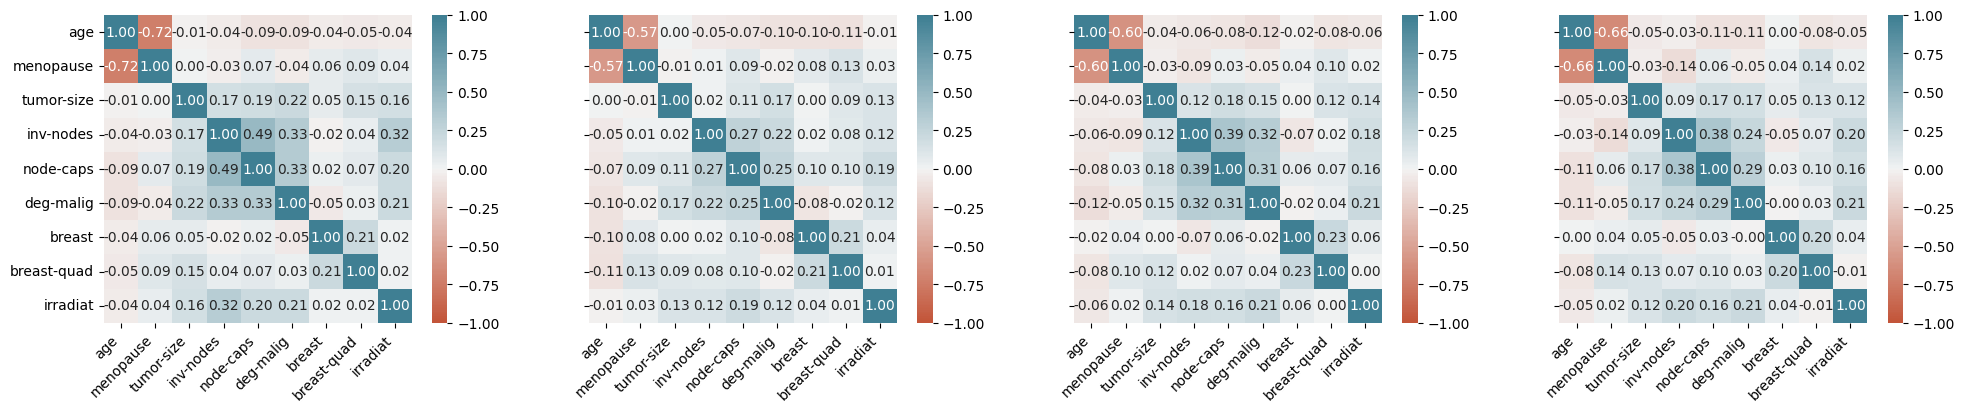

In [21]:
# correlation between ordinal variables in oridinal dataset: original -- random fingerprint -- knn fingerprint
fig, axs = plt.subplots(1, 4, figsize=(24,4), sharey='all')
axs = axs.flat
#fig.suptitle('Correlation matrices')

# original
corr = X.corr()
sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f",
    ax = axs[0]
)
axs[0].set_xticklabels(
    axs[0].get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#axs[0].set_title('Original data')

# random
corr = fp_data_rand.drop(['recurrence'], axis=1).corr()
sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f",
    ax = axs[1]
)
axs[1].set_xticklabels(
    axs[1].get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#axs[1].set_title('Random embedding')

# knn scheme
corr = fp_data_blind.drop(['recurrence'], axis=1).corr()
sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f",
    ax = axs[2]
)
axs[2].set_xticklabels(
    axs[2].get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#axs[2].set_title('NN scheme w/o correlations')

# knn scheme; defined correlations
corr = fp_data_blind_corr.drop(['recurrence'], axis=1).corr()
sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".2f",
    ax = axs[3]
)
axs[3].set_xticklabels(
    axs[3].get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#axs[3].set_title('NN scheme using correlations')

In [22]:
# first decode the values
X['age'] = enc_age.inverse_transform(X['age'])
X['menopause'] = enc_meno.inverse_transform(X['menopause'])

fp_data = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_100.csv')
fp_data = fp_data.drop(['Id'], axis=1)

fp_data_rand = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_random_100.csv')
fp_data_rand = fp_data_rand.drop(['Id'], axis=1)

fp_data_blind = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_100.csv')
fp_data_blind = fp_data_blind.drop(['Id'], axis=1)

fp_data_blind_corr = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_501.csv')
fp_data_blind_corr = fp_data_blind_corr.drop(['Id'], axis=1)

[Text(0.5, 0, '20-29'),
 Text(1.5, 0, '30-39'),
 Text(2.5, 0, '40-49'),
 Text(3.5, 0, '50-59'),
 Text(4.5, 0, '60-69'),
 Text(5.5, 0, '70-79')]

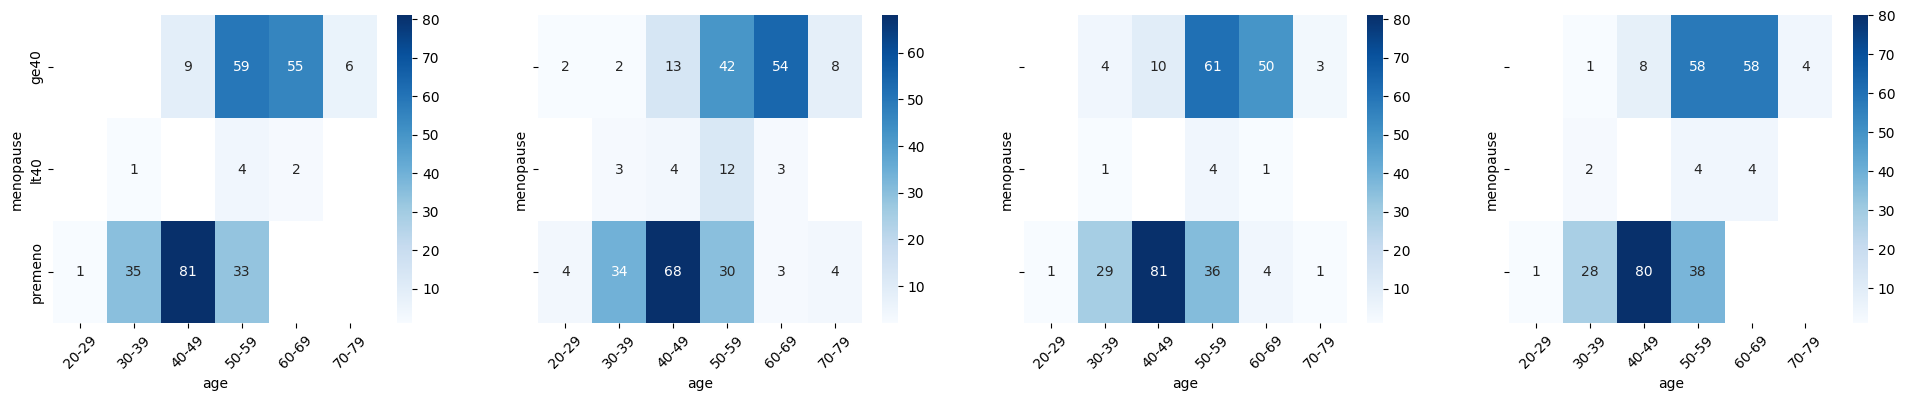

In [23]:
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., age and menopause
fig, axs = plt.subplots(1, 4, figsize=(24,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# age vs menopause
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in X.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('age')
axs[0].set_ylabel('menopause')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
#axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in fp_data_rand.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('age')
axs[1].set_ylabel('menopause')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
#axs[1].set_title('Random embedding')


# NN scheme without correlations
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in fp_data_blind.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('age')
axs[2].set_ylabel('menopause')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
#axs[2].set_title('NN scheme w/o correlations')


# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in fp_data_blind_corr.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('age')
axs[3].set_ylabel('menopause')
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45)
#axs[3].set_title('NN scheme using correlations')

[Text(0.5, 0, '20-29'),
 Text(1.5, 0, '30-39'),
 Text(2.5, 0, '40-49'),
 Text(3.5, 0, '50-59'),
 Text(4.5, 0, '60-69'),
 Text(5.5, 0, '70-79')]

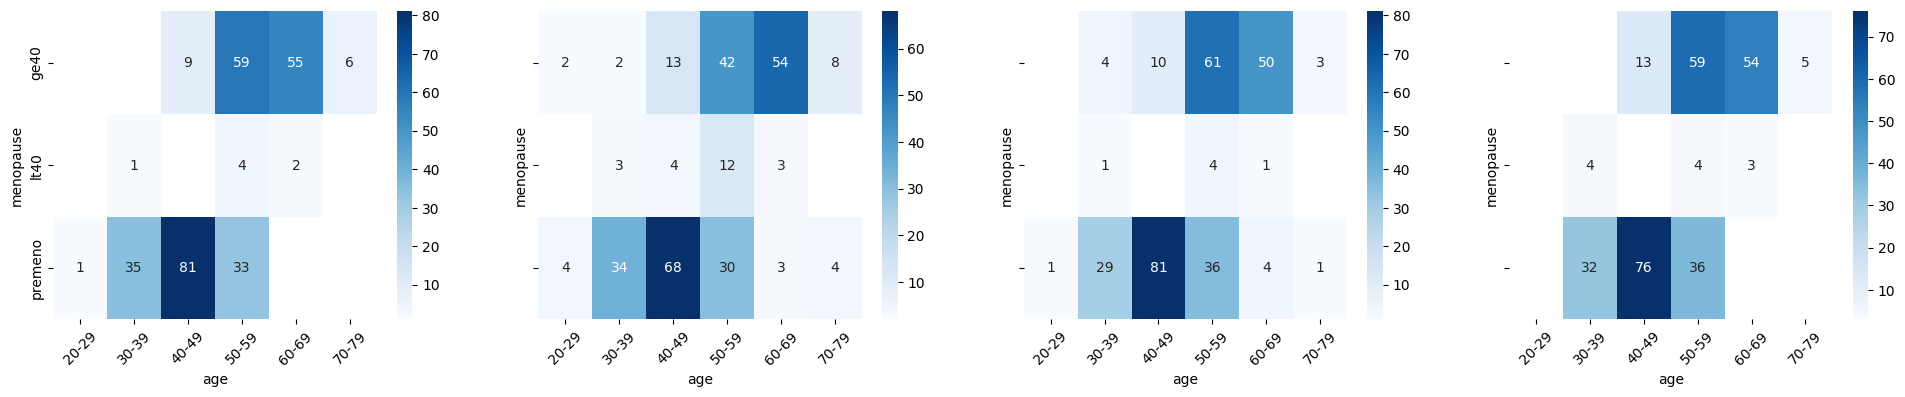

In [26]:
# We investigate the pairwise attribute distributions of correlated attributes.
# E.g., age and menopause
fig, axs = plt.subplots(1, 4, figsize=(24,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# age vs menopause
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in X.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('age')
axs[0].set_ylabel('menopause')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
#axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in fp_data_rand.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('age')
axs[1].set_ylabel('menopause')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
#axs[1].set_title('Random embedding')
columns = df_2dhist.columns

# NN scheme without correlations
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in fp_data_blind.groupby('age')
})
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('age')
axs[2].set_ylabel('menopause')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
#axs[2].set_title('NN scheme w/o correlations')

# NN scheme with correlations
fp_data_blind_corr = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_age_meno_501.csv')
fp_data_blind_corr = fp_data_blind_corr.drop(['Id'], axis=1)
df_2dhist = pd.DataFrame({
    x_label: grp['menopause'].value_counts()
    for x_label, grp in fp_data_blind_corr.groupby('age')
})
df_2dhist['20-29'] = [np.nan, np.nan, np.nan]
df_2dhist = df_2dhist[columns]
sns.heatmap(df_2dhist, cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('age')
axs[3].set_ylabel('menopause')
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45)
#axs[3].set_title('NN scheme using correlations')

In [27]:
# first decode the values
X['node-caps'] = enc_nodecaps.inverse_transform(X['node-caps'])
X['inv-nodes'] = enc_invnodes.inverse_transform(X['inv-nodes'])

In [28]:
fp_data_blind_corr = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_501.csv')
fp_data_blind_corr = fp_data_blind_corr.drop(['Id'], axis=1)

[]

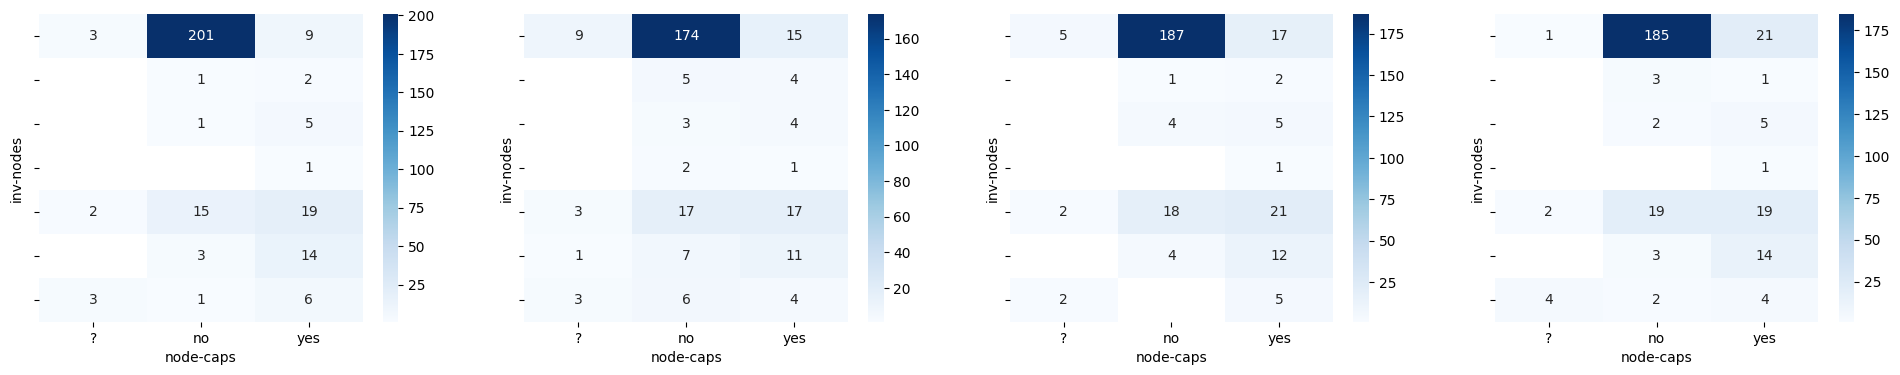

In [29]:
# E.g., inv-nodes and node-caps
fig, axs = plt.subplots(1, 4, figsize=(24,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# node-caps vs inv-nodes
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in X.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('node-caps')
axs[0].set_ylabel('inv-nodes')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=45)
#axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_rand.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('node-caps')
axs[1].set_ylabel('inv-nodes')
axs[1].set_yticklabels(axs[1].get_yticklabels(), rotation=45)
#axs[1].set_title('Random embedding')


# NN scheme without correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('node-caps')
axs[2].set_ylabel('inv-nodes')
axs[2].set_yticklabels(axs[2].get_yticklabels(), rotation=45)
#axs[2].set_title('NN scheme w/o correlations')


# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('node-caps')
axs[3].set_ylabel('inv-nodes')
axs[3].set_yticklabels(axs[3].get_yticklabels(), rotation=45)
#axs[3].set_title('NN scheme using correlations')

In [30]:
# we can see how NN fingerprinting shifts the distribution towards more frequent values instead of the least frequent
# we want to observe whether the amplifications of actual correlations happen in the fingerprinted datasets
# for example, in the histograms above, we see significantly increased occurence in top row for node-caps: yes (from 9 to 21)

In [31]:
fp_data_blind_corr_0 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_101.csv')
fp_data_blind_corr_0 = fp_data_blind_corr_0.drop(['Id'], axis=1)
fp_data_blind_corr_1 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_201.csv')
fp_data_blind_corr_1 = fp_data_blind_corr_1.drop(['Id'], axis=1)
fp_data_blind_corr_2 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_301.csv')
fp_data_blind_corr_2 = fp_data_blind_corr_2.drop(['Id'], axis=1)
fp_data_blind_corr_3 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_401.csv')
fp_data_blind_corr_3 = fp_data_blind_corr_3.drop(['Id'], axis=1)

[]

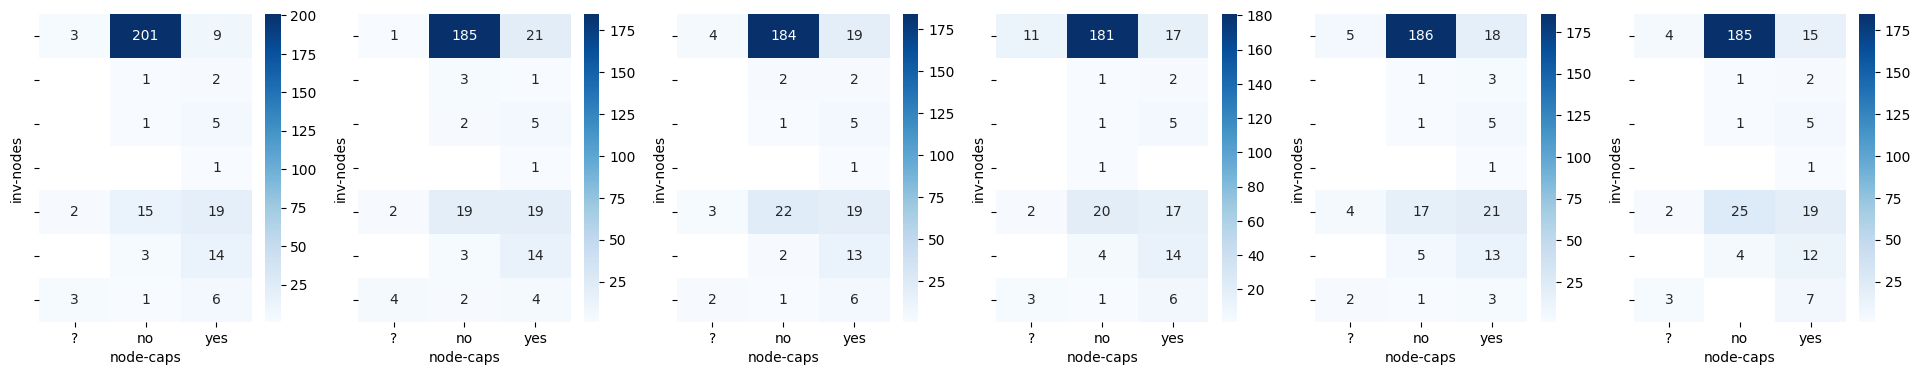

In [36]:
# E.g., inv-nodes and node-caps
fig, axs = plt.subplots(1, 6, figsize=(24,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# node-caps vs inv-nodes
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in X.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('node-caps')
axs[0].set_ylabel('inv-nodes')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=45)
#axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('node-caps')
axs[1].set_ylabel('inv-nodes')
axs[1].set_yticklabels(axs[1].get_yticklabels(), rotation=45)
#axs[1].set_title('Random embedding')


# NN scheme without correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_0.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('node-caps')
axs[2].set_ylabel('inv-nodes')
axs[2].set_yticklabels(axs[2].get_yticklabels(), rotation=45)
#axs[2].set_title('NN scheme w/o correlations')


# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_1.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('node-caps')
axs[3].set_ylabel('inv-nodes')
axs[3].set_yticklabels(axs[3].get_yticklabels(), rotation=45)
#axs[3].set_title('NN scheme using correlations')

# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_2.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[4])
axs[4].set_xlabel('node-caps')
axs[4].set_ylabel('inv-nodes')
axs[4].set_yticklabels(axs[4].get_yticklabels(), rotation=45)
#axs[4].set_title('NN scheme using correlations')

# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_3.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[5])
axs[5].set_xlabel('node-caps')
axs[5].set_ylabel('inv-nodes')
axs[5].set_yticklabels(axs[5].get_yticklabels(), rotation=45)
#axs[5].set_title('NN scheme using correlations')

In [38]:
# the trend seems to exist for the case where one value pair is overly represented
# this makes sense because the marking algorithm will push some values towards less frequent (if marking bit is 0)
# we need this for robustness!

# let's observe larger gamma (less marks)

In [45]:
fp_data_blind_corr_0_g2 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_101_g2.csv')
fp_data_blind_corr_0_g2 = fp_data_blind_corr_0_g2.drop(['Id'], axis=1)
fp_data_blind_corr_1_g2 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_201_g2.csv')
fp_data_blind_corr_1_g2 = fp_data_blind_corr_1_g2.drop(['Id'], axis=1)
fp_data_blind_corr_2_g2 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_301_g2.csv')
fp_data_blind_corr_2_g2 = fp_data_blind_corr_2_g2.drop(['Id'], axis=1)
fp_data_blind_corr_3_g2 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_401_g2.csv')
fp_data_blind_corr_3_g2 = fp_data_blind_corr_3_g2.drop(['Id'], axis=1)
fp_data_blind_corr_4_g2 = pd.read_csv('NCorrFP_scheme/outfiles/fp_data_blind_corr_inv_node_501_g2.csv')
fp_data_blind_corr_4_g2 = fp_data_blind_corr_4_g2.drop(['Id'], axis=1)

[]

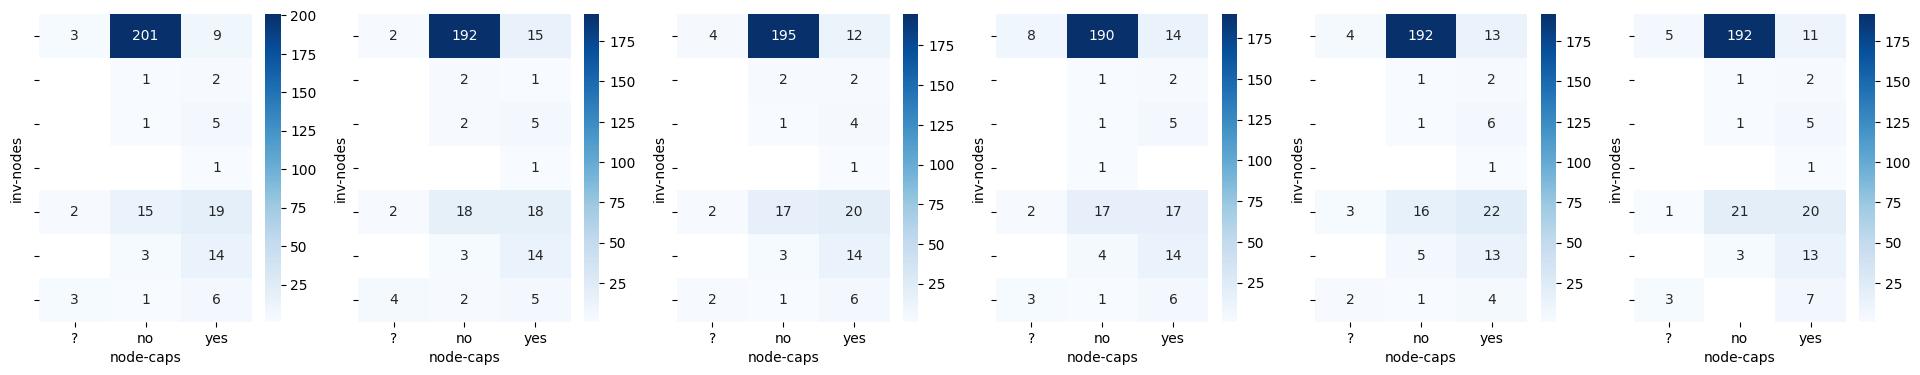

In [46]:
# E.g., inv-nodes and node-caps
fig, axs = plt.subplots(1, 6, figsize=(24,4), sharey='all')
axs = axs.flat
#fig.suptitle('Pairwise attribute distributions')

############
# ORIGINAL #
############
# node-caps vs inv-nodes
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in X.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[0])
axs[0].set_xlabel('node-caps')
axs[0].set_ylabel('inv-nodes')
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=45)
#axs[0].set_title('Original data')


# random embedding
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_4_g2.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[1])
axs[1].set_xlabel('node-caps')
axs[1].set_ylabel('inv-nodes')
axs[1].set_yticklabels(axs[1].get_yticklabels(), rotation=45)
#axs[1].set_title('Random embedding')


# NN scheme without correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_0_g2.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[2])
axs[2].set_xlabel('node-caps')
axs[2].set_ylabel('inv-nodes')
axs[2].set_yticklabels(axs[2].get_yticklabels(), rotation=45)
#axs[2].set_title('NN scheme w/o correlations')


# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_1_g2.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[3])
axs[3].set_xlabel('node-caps')
axs[3].set_ylabel('inv-nodes')
axs[3].set_yticklabels(axs[3].get_yticklabels(), rotation=45)
#axs[3].set_title('NN scheme using correlations')

# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_2_g2.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[4])
axs[4].set_xlabel('node-caps')
axs[4].set_ylabel('inv-nodes')
axs[4].set_yticklabels(axs[4].get_yticklabels(), rotation=45)
#axs[4].set_title('NN scheme using correlations')

# NN scheme with correlations
df_2dhist = pd.DataFrame({
    x_label: grp['inv-nodes'].value_counts()
    for x_label, grp in fp_data_blind_corr_3_g2.groupby('node-caps')
})
sns.heatmap(df_2dhist, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True), annot=True, ax=axs[5])
axs[5].set_xlabel('node-caps')
axs[5].set_ylabel('inv-nodes')
axs[5].set_yticklabels(axs[5].get_yticklabels(), rotation=45)
#axs[5].set_title('NN scheme using correlations')